# Projet Final - GBM8770
## Multi-Scale Line Detector

Équipe #22
- Beaudry, Sophie (Matricule)
- Nom, Prénom (Matricule)

In [1]:
# Vous permet de modifier vos fichiers importés et que les changements soient appliqués
# automatiquement, sans avoir à redémarer le notebook.
%load_ext autoreload  
%autoreload 2         

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology as skmorph

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)  # Étend la taille des figures

In [2]:
from src.algo import MultiScaleLineDetector, dice, learn_threshold, naive_metrics
from src.dataset import Sample, load_dataset
from src.viz import plot_roc, show_diff


# 1. Implémentation de la MSLD

## 1.1. Préparatifs

Pour entraîner et valider l’algorithme, nous allons utiliser la base de données DRIVE fournie dans l'archive.


**Q1.** Complétez la fonction `load_dataset()` pour qu’elle charge et renvoie la base de données d’entraînement et de test (en incluant pour chaque échantillon: l’image, le label et le masque). Puis affichez l’image, le label et le masque de la première image de l’ensemble d’entraînement.

*(On notera cette image I1.)*

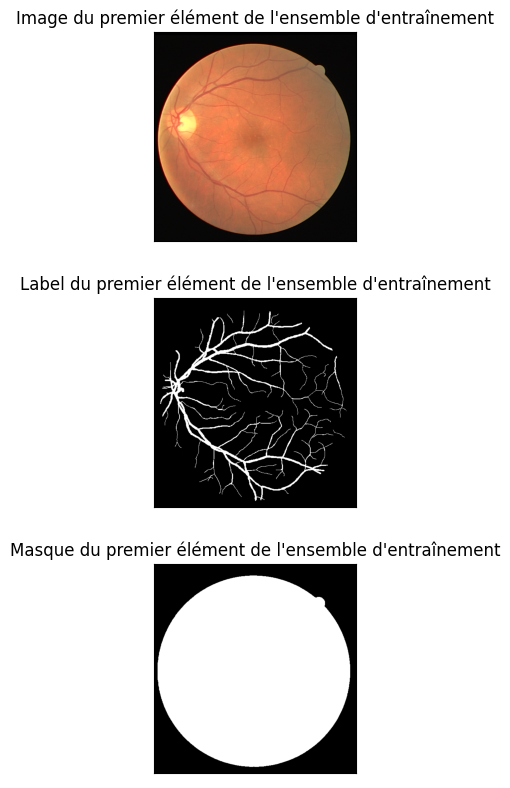

In [ ]:
train, test = load_dataset()
I1 = train[0]

fig, axes = plt.subplots(3, 1)
fig.tight_layout(h_pad=2.0)

for ax in axes: # À demander à Sophie
    ax.set_xticks([])
    ax.set_yticks([])

axes[0].set_title("Image du premier élément de l'ensemble d'entraînement")
axes[0].imshow(I1.image, cmap='gray')
axes[1].set_title("Label du premier élément de l'ensemble d'entraînement")
axes[1].imshow(I1.label, cmap="gray")
axes[2].set_title("Masque du premier élément de l'ensemble d'entraînement")
axes[2].imshow(I1.mask, cmap="gray")
plt.show()


## 1.2. Basic Line Detector

Dans un soucis d’optimisation de l’implémentation, nous allons utiliser des convolutions dès que cela est possible. Particulièrement pour le calcul des moyennes d’intensités sur une fenêtre de taille `W` et le long des lignes de longueur `L`. De plus ces masques ne seront calculés qu’une seule fois, lors de l’instanciation de la classe MSLD.

**Q1.** Quel filtre de convolution permet le calcul de la valeur moyenne d’une fenêtre de taille `W` autour d'un pixel ? Complétez le constructeur de la classe `MultiScaleLineDetector` en définissant `avg_mask`.


Le filtre moyenneur permet le calcul de la valeur moyenne d'un pixel par une convolution. Celui-ci est simplement créé en prenant une matrice de 1 de taille WxW, puis en la divisant par la somme de ces composantes.

**Q2.** On souhaite implémenter le BLD en utilisant des masques de convolution. Ces masques viendront sélectionner les pixels le long d'une ligne. Ils seront définis par leur longuer `L` et une série d'orientations. Expliquez comment construire les masques pour permettre le calcul de la valeur moyenne le long de lignes de taille `L` pour `num_orientations`. Complétez le constructeur de la classe `MultiScaleLineDetector` avec la définition de `line_detectors_masks`.

Pour construire les masques permettant le calcul de la valeur moyenne le long des lignes, nous commençons par créer le masque de la ligne horizontale. Ce masque est créé  en superposant des vecteurs de zéro ou de un de dimension (1, `l`). Cette technique suppose que les valeurs dans `L` sont tous impairs. Nous tournons ensuite ce masque à l'aide d'une matrice de rotation standard en 2D. La variable `num_orientations` est utilisée afin de déterminer les angles à utiliser lors de la rotation. 

In [4]:
# Vous pouvez dès à présent instancier l'objet MSLD en remplaçant les hyper-paramètres W, L et num_orientations par
# leurs valeurs conseillées par l'article.
msld = MultiScaleLineDetector(W=15, L=[1, 3, 5, 7, 9, 11, 13, 15], num_orientations=12)

**Q3.** À l’aide de la section 3.1 de l’article, implémentez `basic_line_detector(grey_lvl, L)`.

**Q4.** Affichez la réponse du filtre appliqué à l’image I1 pour les longueurs L=1 et L=15. Comparez les deux et commentez.   

*Note: Attention le filtre BLD ne s’applique pas à tous les canaux de l’image. Relisez la section 3.1 de l’article pour plus d’informations...*

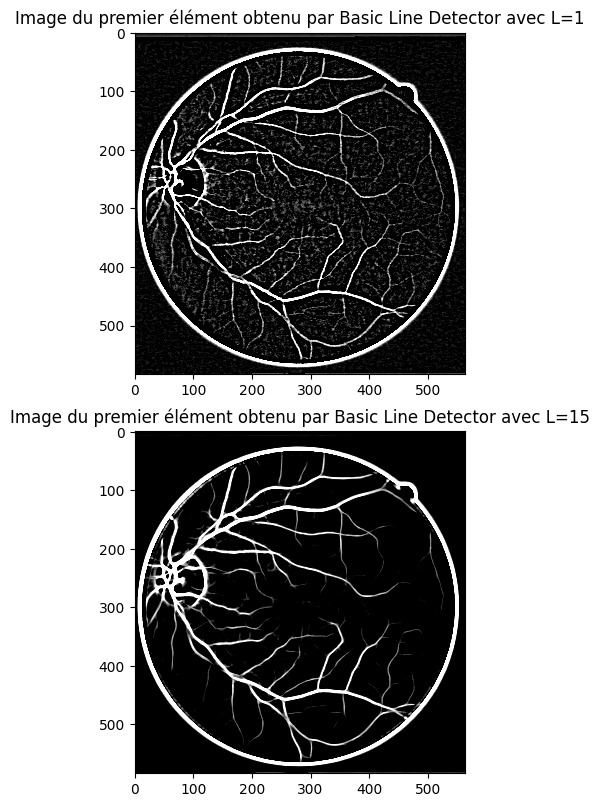

In [5]:
grey_lvl_I1 = 1-I1.image[:,:, 1] # on inverse le canal vert
I1_bld_L1 = msld.basic_line_detector(grey_lvl_I1, L=1)
I1_bld_L15 = msld.basic_line_detector(grey_lvl_I1, L=15)

fig, axes = plt.subplots(2, 1)
fig.tight_layout(h_pad=2.0)

axes[0].set_title("Image du premier élément obtenu par Basic Line Detector avec L=1")
axes[0].imshow(I1_bld_L1, cmap='gray', vmin=0.0, vmax=1.0)
axes[1].set_title("Image du premier élément obtenu par Basic Line Detector avec L=15")
axes[1].imshow(I1_bld_L15, cmap="gray", vmin=0.0, vmax=1.0)

plt.show()


Tel que discuté dans l'article, on remarque qu'avec une plus petite longueur de ligne L, l'image segmentée contient davantage de bruit et les contours des vaisseaux sont moins bien définis. Cependant, lorsque L augmente, on remarque que certains vaisseaux ont tendance à se fusionner ou à se scinder dans la segmentation. Ce résultat est logique, car pour de petites lignes, le bruit impulsionnel n'est pas dilué par les différents masques utilisés. Ainsi, il apparaît comme un vaisseau dans notre segmentation. De plus, pour de grandes lignes, comme la région de pixels considérée est très grande et que l'algorithme segmente en fonction de l'intensité moyenne sur cette région, ce dernier peut segmenter à tord le fond entre deux vaisseaux très intenses ou des vaisseaux très minces sur un fond prononcé.

## 1.3. Multi-Scale Line Detector

**Q1.** À l’aide des sections 3.2 et 3.3 de l’article et de la méthode `self.basic_line_detector(grey_lvl, L)` déjà implémentée, implémentez `multi_scale_line_detector(image)`.

**Q2.** Affichez le résultat de l’algorithme appliqué à l’image I1. Comparez avec les réponses du filtre obtenues à la question 1.2.4, et commentez.

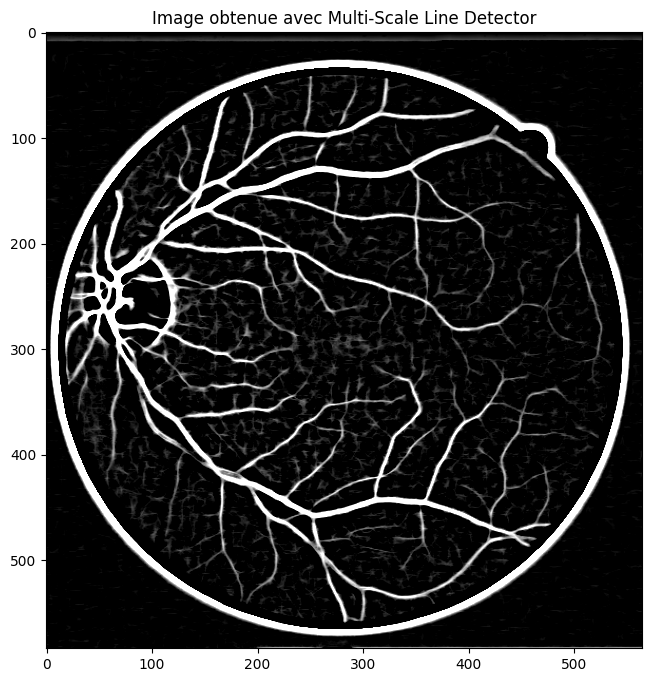

In [6]:
I1_msld = msld.multi_scale_line_detector(I1.image)
plt.title("Image obtenue avec Multi-Scale Line Detector")
plt.imshow(I1_msld, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()


## 1.4. Apprentissage du seuil
 
Pour calculer le seuil donnant la meilleure précision sur l’ensemble d’entraînement efficacement, nous allons utiliser la courbe [ROC (Receiver Operating Characteristic)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Cette courbe sera étudiée en détail dans la partie 2. Pour le moment, il vous faut juste savoir qu’elle associe à chaque seuil possible, le taux de faux positifs et le taux de vrais positifs si ce seuil était choisi.

**Q1.** Donnez la formule de la précision ACC (*accuracy* en anglais) en fonction du taux de faux positifs FPR, du taux de vrais positifs TPR, ainsi que du nombre de valeurs positives P, de valeurs négatives N et du nombre total de pixels S de la région d'intéret.   

Utilisez la syntaxe $\LaTeX$ pour formatter l'équation.

*(Vous pouvez vous aider des formules indiqués sur la page Wikipédia de la courbe ROC.)*

$ ACC = \frac{TPR \cdot P + (1 - FPR) \cdot N}{S} $

Pour vous faire gagner du temps, on vous donne la fonction `roc(msld, dataset)` qui calcule le TPR et le FPR associé à chaque seuil possible pour un dataset donné. Cette fonction utilise la fonction [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) de `sklearn`. Assurez-vous que vous comprenez bien chaque ligne du code.

**Q2.** Pourquoi est-il si important de ne sélectionner uniquement les pixels qui appartiennent au masque? En particulier, comment évoluerait la précision si on sélectionnait finalement tous les pixels de l'image (sachant que hors du masque la prédiction du MSLD est toujours nulle)?

Si tous les pixels de l'image était considérés dans le calcul de la précision, alors le nombre de pixels de fond seraient nettement supérieur au nombre de pixels représentant un vaisseau sanguin. Cette différence significative entre la taille des deux classes diminuerait la signification statistique de la métrique calculée, car un modèle qui classifierait bêtement tous les pixels au groupe de fond obtiendrait tout de même une bonne précision globale.

**Q3.** À l’aide de la fonction `roc(msld, dataset)` et de la formule de la question 1 de cet exercice, complétez la fonction
`learn_threshold(msld, dataset)` qui identifie le seuil pour laquelle la précision est la plus élevée.


**Q4.** Utilisez cette fonction pour apprendre le seuil sur les images d’entraînement. Pour quelle raison faut il absolument conserver une partie des images (l’ensemble de test) et ne pas les utiliser pendant l’entraînement?

*N.B.: il n’est pas anormal d’obtenir un seuil différent de celui annoncé par les auteurs...*


In [7]:
threshold, accuracy = learn_threshold(msld, train)

In [8]:
print(f"Le meilleur seuil est {threshold:.4f}.")
print(f"La précision associée est de {accuracy:.4f}.")

Le meilleur seuil est 0.5645.
La précision associée est de 0.9249.


Il est important de séparer nos données en un ensemble d'entraînement et un ensemble de test afin de ne pas présenter des métriques statistiques de notre modèle sur un ensemble de données où les hyperparamètres du modèle lui ont été surajustés. Ces métriques ne représentent alors plus la capacité de notre modèle de se généraliser à d'autres ensembles de données et perdent de leur valeur statistique.

## 1.5. Affichage et région d’intérêt

**Q1.** Implémentez la méthode `segment_vessels(image, threshold)` qui applique le seuil à la carte de probabilité calculée sur une image. Affichez le résultat de l’algorithme sur l’image I1.


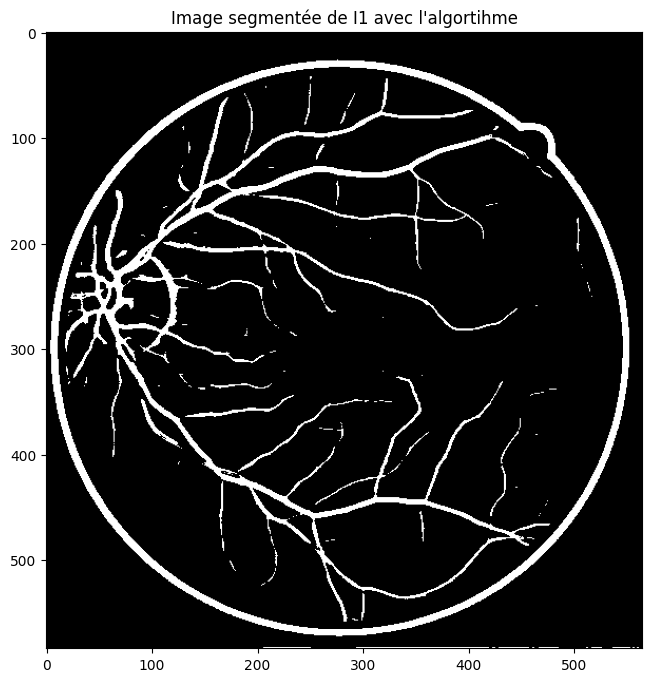

In [9]:
I1_vaisseau=msld.segment_vessels(I1.image, threshold)
plt.title("Image segmentée de I1 avec l'algortihme")
plt.imshow(I1_vaisseau, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()


**Q2.**  Vous devriez voir apparaître des erreurs de segmentations aux bords du fond d’oeil (à la frontière circulaire entre le fond d'oeil et le fond noir). À quoi est dû ce phénomène?



En inversant le canal vert de notre image, le fond noir autour de l'image de l'oeil est devenu très intense. Ainsi, lorsque le masque de notre algorithme passe sur ces régions, il interprête la grande variation d'intensité entre le fond de l'oeil, d'intensité faible sur l'image inversé, et le fond noir comme la présence d'un vaisseau sanguin.

**Q3.** Pour palier à ce problème, dupliquez les datasets, érodez la région d'intérêt (le masque) de manière à réduire le diamètre de 10 pixels, puis effectuez l'apprentissage du seuil à nouveau. Comparez les valeurs de seuil et la précision globale.



In [10]:
# Duplique les dataset
train_eroded = deepcopy(train)
test_eroded = deepcopy(test)

for d in train_eroded:
    # Erosion
    d.mask = skmorph.binary_erosion(d.mask, skmorph.disk(5))

# Même opération pour test_eroded
for d in test_eroded:
    # Erosion
    d.mask = skmorph.binary_erosion(d.mask, skmorph.disk(5))

I1_eroded = train_eroded[0]

In [11]:
new_threshold, new_accuracy = learn_threshold(msld, train_eroded)

In [29]:
print(f"Le meilleur seuil est à {new_threshold:.4f} lorsque les masques érodés sont utilisés.")
print(f"La nouvelle précision associée est de {new_accuracy:.4f}.")



Le meilleur seuil est à 0.5645 lorsque les masques érodés sont utilisés.
La nouvelle précision associée est de 0.9338.


**Q4.** On vous donne la fonction `show_diff(msld, sample, threshold, ax)` qui affiche les faux positifs en rouge, les faux négatifs en bleu, les vrais positifs en blanc et les vrais négatifs en noirs. Avec cette fonction, affichez la différence entre la prédiction et le label sur l’image I1. Commentez le résultat.

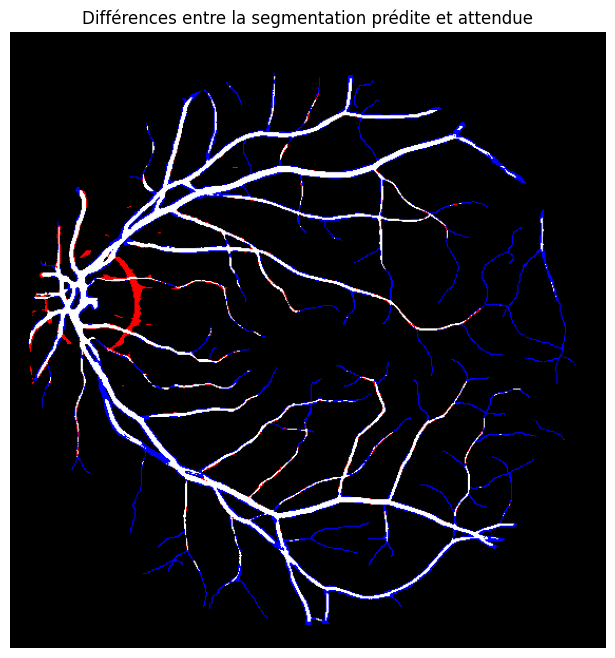

In [13]:
fig, ax = plt.subplots(1, 1)

show_diff(msld, I1_eroded, new_threshold, ax)
plt.show()


En observant les différences entre la segmentation obtenue avec notre algorithme et celle attendue, nous pouvons aussi observer que notre algorithme segmente à tord la frontière délimitant le nerf optique comme étant des vaisseaux sanguins. Cette erreur est dû au fort contraste entre ces deux régions. De plus, nous pouvons aussi remarquer que notre algorithme ne parvient pas à segmenter correctement les extrémités du réseau vasculaire. Ce résultat provient de la combinaison du faible contraste dans ces régions et de l'utilisation d'un seuil pour filtrer le bruit. Ainsi, les extrémités des vaisseux sanguins sont perdues lors de notre segmentation, car elles sont considérées comme du bruit par notre algorithme.

# 2. Métriques de segmentation

## 2.1. Précision globale et locale

**Q1.** Implémentez la fonction `naive_metrics(msld, dataset, threshold)` qui évalue la précision et la matrice de confusion de l’algorithme pour un dataset donné. Puis calculez ces métriques sur l’ensemble de test.
*(N’oubliez pas de ne sélectionner que les pixels appartenant à la région d’intérêt!)*


In [ ]:
accuracy, confusion_matrix = naive_metrics(msld, test_eroded, new_threshold) # À demander aux chargés pour la normalisation

confusion_matrix_format = np.array([["TP", "FN"], ["FP", "TN"]])

print(f"La précision globale du modèle est de {accuracy:.4f}.")
print(f"La matrice de confusion du modèle est donnée ci-dessous : \n{confusion_matrix}\n\nLes données de cette matrice respectent le format suivant : \n{confusion_matrix_format}")

La précision globale du modèle est de 0.9382.
La matrice de confusion du modèle est donnée ci-dessous : 
[[0.08183908 0.04854867]
 [0.01324828 0.85636397]]

Les données de cette matrice respectent le format suivant : 
[['TP' 'FN']
 ['FP' 'TN']]


**Q2.** Utilisez la fonction `show_diff` pour afficher la prédiction sur `I1` à différents seuils et calculez la précision associée à chacun de ces seuils. Indiquez la valeur du seuil et la précision dans le titre de chaque carte de différence. Commentez sur l'effet du seuil.

Précision globale pour un seuil 0.3 : 0.9271353715186211
Précision globale pour un seuil 0.5 : 0.9389324343178133
Précision globale pour un seuil 0.5644700527191162 : 0.9382030515599734
Précision globale pour un seuil 0.6 : 0.9373734901731169
Précision globale pour un seuil 0.8 : 0.9300012122071548


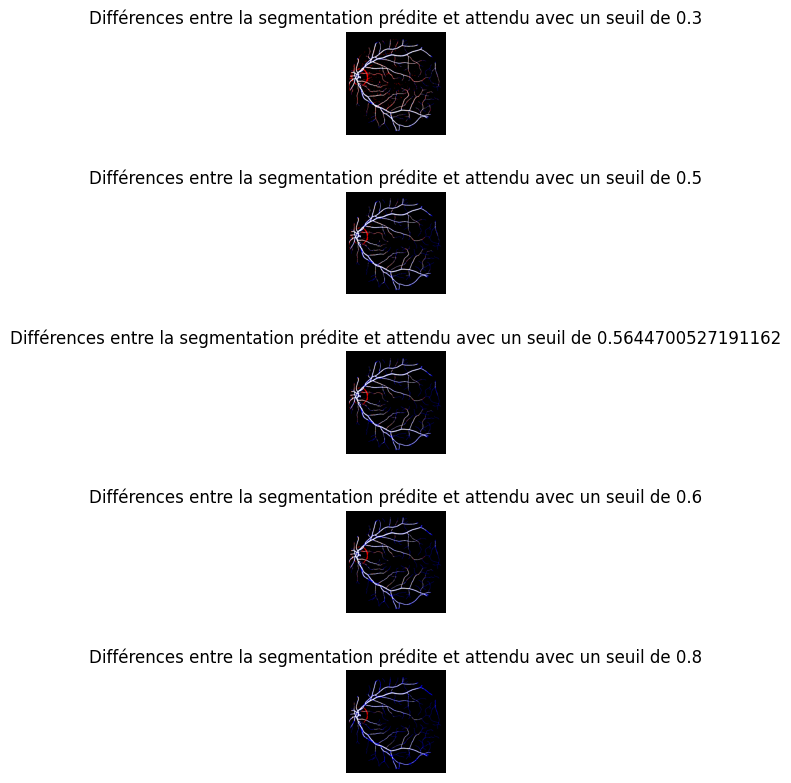

In [ ]:
seuils = [0.3, 0.5, new_threshold, 0.6, 0.8] # À demander avec les chargés de TD

fig, axes = plt.subplots(5, 1) # Format à fix
fig.tight_layout(h_pad=2.0)

for seuil, ax in zip(seuils, axes):

    accuracy, _ = naive_metrics(msld, test_eroded, seuil)

    show_diff(msld, I1_eroded, seuil, ax)
    ax.set_title(f"Différences entre la segmentation prédite et attendu avec un seuil de {seuil:.2f}")
    print(f"Précision globale pour un seuil {seuil:.2f} : {accuracy:.2f}")

plt.show()

**Q3.** Les auteurs proposent une seconde métrique: la précision locale. Quelles raisons avancent-ils
pour motiver cette proposition?


Puisque les pixel de fond occupent plus de 80% des images d'une rétine normale, la précision globale de tous les modèles utilisés est très haute. Ainsi, il est plus difficile de comparer les modèles entre eux. En calculant la précision sur une région obtenue en dilatant le label utilisé avec élément structurant de taille 3, le nombre de pixels de fond approche le nombre de pixels de vaisseau. Ainsi, la précision locale donne une meilleure idée de la performance du modèle. De plus, selon les hypothèses des auteurs, le modèle proposé est sensé avoir une meilleure précision pour la segmentation des vaisseaux aux embranchements et lorsque deux vaisseaux sont très près l'un de l'autre. Ainsi, l'utilisation de la précision locale permet de mieux démontrer cette hypothèse de recherche.

**Q4.** Grâce à une opération morphologique, créez une copie du dataset ``test`` tel que son attribut mask corresponde à la région d’intérêt "locale" proposée par les auteurs. Puis, sans modifier la fonction `naive_metrics(msld, dataset, threshold)`, calculez la précision et la matrice de confusion locale.


In [31]:
test_local = deepcopy(test)

for d in test_local:
    # Dilatation du label pour former le masque
    d.mask = skmorph.binary_dilation(d.label, skmorph.square(3)) # Taille et forme?

In [32]:
local_accuracy, local_confusion_matrix = naive_metrics(msld, test_local, new_threshold)

print(f"La précision locale du modèle est de {local_accuracy:.4f} lorsque l'élément structurant utilisé dans la dilatation du label est un cercle de rayon 3.")
print(f"La matrice de confusion du modèle est donnée ci-dessous : \n{local_confusion_matrix}\n\nLes données de cette matrice respectent le format suivant : \n{confusion_matrix_format}")

La précision locale du modèle est de 0.7515 lorsque l'élément structurant utilisé dans la dilatation du label est un cercle de rayon 3.
La matrice de confusion du modèle est donnée ci-dessous : 
[[0.34324162 0.21116282]
 [0.03730499 0.40829057]]

Les données de cette matrice respectent le format suivant : 
[['TP' 'FN']
 ['FP' 'TN']]


**Q5.** Cette seconde métrique met plus en valeur l’algorithme proposé que la précision globale. Au vu des erreurs de l’algorithme révélées à la question 4 de l'exercice I.5, donnez une raison supplémentaire (omise par les auteurs) qui explique ce phénomène. 

L'algorithme utilisé effectue une mauvaise segmentation des pixels autour du disque optique, puisqu'il interprète la forte variation de contraste entre le fond de l'oeil et le disque optique comme la présence d'un vaisseau sanguin. Or, cette région est négligée lors du calcul de précision locale. Ainsi, cette métrique met plus en valeur l'algorithme proposé, puisqu'il masque les effets de ce défault.

## 2.2. Indice Dice (bonus)
De nombreux indices existent pour mieux évaluer les performances de segmentation que la précision globale: précision balancée, indice de Jaccard, kappa de Cohen, etc. Nous allons ici utiliser l'indice Sørensen-Dice. En notant $Y$ les labels et $\hat{Y}$ les prédictions de l'algorithme, l'indice Dice est défini par
$$\text{Dice}(Y, \hat{Y}) = 2\dfrac{Y \cap \hat{Y}}{Y + \hat{Y}}.$$

**Q1.** En quoi cette métrique répond aux limitations de la précision globale?

**Q2.** Implémentez la fonction `dice(msld, dataset, threshold)` et calculez sa valeur sur la région d’intérêt globale et locale sur l’ensemble de test.


## 2.3. Courbe ROC et aire sous la courbe


Le choix d’un seuil de segmentation revient à faire un compromis entre faux-positifs et faux-négatifs (un seuil élevé limitera les faux-positifs mais augmentera les faux-négatifs et inversement). Le choix du bon compromis dépend bien souvent de l’application. Cependant les algorithmes se distinguent par le choix des caractéristiques à seuiller (ici un filtre MSLD) plutôt que par la méthode de sélection du seuil... [La courbe ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve) permet de représenter les performances de l’algorithme indépendamment du seuil choisi.   

Pour construire cette courbe, on calcule le taux de faux-positifs (FPR) et le taux de vrais-positifs (TPR=1−FNR) pour chaque valeur de seuil. La courbe obtenue (FPR en abscisse, TPR en ordonnée) caractérise l’efficacité de l’algorithme à distinguer les vaisseaux du fond, indépendamment du seuil.

Enfin, pour simplifier la comparaison entre deux courbes ROC, on extrait leurs [aires sous la courbe (AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve).

**Q1.** Que signifie une AUC de 1, de 0,5 ou de 0 pour les performances du modèle?


**Q2.**  Implémentez la fonction `plot_roc(msld, dataset, ax)` qui trace la courbe ROC et calcule son AUC. Puis faites de même pour la région d’intérêt globale et pour la région d’intérêt locale. Comparez les résultats et commentez.

# 3. Validation de l’hypothèse de recherche de l’article

À l’aide de votre implémentation de l’algorithme et des différents cas du dataset de test, discutez de la qualité du protocole expérimental pour vérifier les hypothèses de recherche sous-jacentes de l’article (telles que vous les aviez formulé dans le devoir 2).

# 4. Discussion



**Q1.** Discutez du choix des hyper-paramètres `W`, `L` (nombre d’échelles et répartition) et `num_orientations`. Leurs valeurs ont-elles des justifications théoriques? Quels sont leur impact en pratique?

**Q2.** Les auteurs ont choisi le seuil donnant la meilleure précision sur l’ensemble d’entraînement. Connaissant les analyses effectuées dans la partie 2, discutez de ce choix.

**Q3.** En vous appuyant sur vos expérimentations pour les deux dernières parties de cet énoncé, proposez des recommandations pour améliorer l’algorithme.